In [ ]:
import sys
sys.path.append('.')
import IceWeb

st = 

spobj = IceWeb.icewebSpectrogram(stream=st)

/Users/thompsong/.local/lib/python3.8/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
/Users/thompsong/.local/lib/python3.8/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
/Users/thompsong/.local/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


2 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2019-12-08T00:00:00.003134Z - 2019-12-09T02:00:00.003134Z | 100.0 Hz, 9360001 samples
NZ.WSRZ.10.HHZ | 2019-12-08T00:00:00.003119Z - 2019-12-09T02:00:00.003119Z | 100.0 Hz, 9360001 samples
Done.


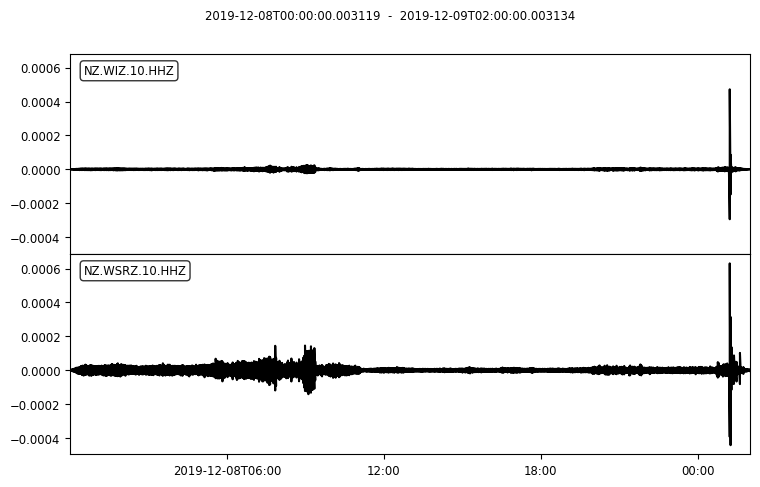

In [2]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client

# These 2 lines give us access to the GeoNET (New Zealand) digital seismic network data
#from obspy.clients.fdsn import Client as FDSN_Client
client_geonet = Client("GEONET")

# Define the data that we want
start_time = obspy.UTCDateTime("2019-12-08T00:00:00.000")
hours_of_data = 26
end_time = start_time + hours_of_data * 60 * 60
net = "NZ" # New Zealand national network
stations = ["WIZ", "WSRZ"] # two stations on White Island
chan = "HHZ" # Vertical high-rate channel (100 samples per second)

# Loading data from the GeoNET client is slow. So when we read it, we will save it to a file. 
# Then if we run this program again, we just need to read the file.
fname = 'WhiteIslandFinal26Hours_VEL.mseed'
if os.path.exists(fname):
    # the file already exists, so read it
    print("%s exists. Reading." % fname)
    VEL = obspy.read(fname)
else:
    st = obspy.Stream() # this will hold our raw seismic data
    for station in stations:   
        this_st = client_geonet.get_waveforms(net, station,"*", chan, start_time, end_time, attach_response=True)
        for tr in this_st:
            st = st.append(tr)
    
    # remove instrument response
    VEL = st.copy()
    VEL.detrend(type='linear') # remove a linear trend
    VEL.filter('bandpass', freqmin=0.1, freqmax=25.0, zerophase=True, corners=2) # filter from 0.1 - 25 Hz
    VEL.remove_response(output='VEL')
    VEL.write(fname)
print(VEL)
print('Done.')
VEL.plot();

In [9]:
def compute_rsam(st, rsam_sampling_interval):
    # Inputs:
    #    st: a Stream object
    #    rsam_sampling_interval: sampling interval for RSAM data (in seconds)
    # Outputs:
    #    rsam_stream: a downsampled Stream object. 
    
    rsam_stream = st.copy() # we copy the input as it is passed-by-reference and would otherwise be changed in place
    
    for tr in rsam_stream: # Loop over each trace (seismogram)
        x = tr.data # get the data
        
        # now we want to reshape the data vector into an array, so we can take advantage of np.mean()
        s = np.size(x) # find the size of the data vector
        print('%s: size %d' % (tr.id, s))
        nc = int(tr.stats.sampling_rate * rsam_sampling_interval) # number of columns
        nr = int(s / nc) # number of rows
        x = x[0:nr*nc] # cut off any trailing samples
        y = x.reshape((nr, nc))
        print('%s: reshaped to %d x %d array (%d samples)' % (tr.id, nr, nc, nr * nc))
        tr.data = np.mean(abs(y),axis=1) # compute mean for each row (this is vectorised; faster than a for loop)
        tr.stats.sampling_rate = 1.0 / rsam_sampling_interval # update the sampling rate
        print(tr.stats)
        print("")
        
    return rsam_stream


def plot_rsam(st):
    hf = st.plot(handle=True); # standard ObsPy plot
    
    # change the y-axis so it starts at 0
    allAxes = hf.get_axes()
    for ax in allAxes:
        ylims = ax.get_ylim()
        ax.set_ylim([0, ylims[1]])
        
def write_rsam(rsamfile, tr):
    f = open(rsamfile, "w")
    dt = tr.times(type="UTCDateTime")
    f.write('year, month, day, hour, minute, second, data\n')
    for i in range(len(tr.data)):
        f.write("%s, %e\n" % (dt[i].strftime('%Y, %m, %d, %H, %M, %S'), tr.data[i]) )
    f.close()

NZ.WIZ.10.HHZ: size 9360001
NZ.WIZ.10.HHZ: reshaped to 36562 x 256 array (9359872 samples)
               network: NZ
               station: WIZ
              location: 10
               channel: HHZ
             starttime: 2019-12-08T00:00:00.003134Z
               endtime: 2019-12-09T01:59:56.163134Z
         sampling_rate: 0.390625
                 delta: 2.56
                  npts: 36562
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 28666, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 14676992})
            processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 12, 9, 2, 0, 0, 3134)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 12, 8, 0, 0, 0, 3134))', "ObsPy 1.3.0: detrend(options={}::type='linear')", "ObsPy 1.3.0: filter(options={'freqmin': 0.1, 'freq

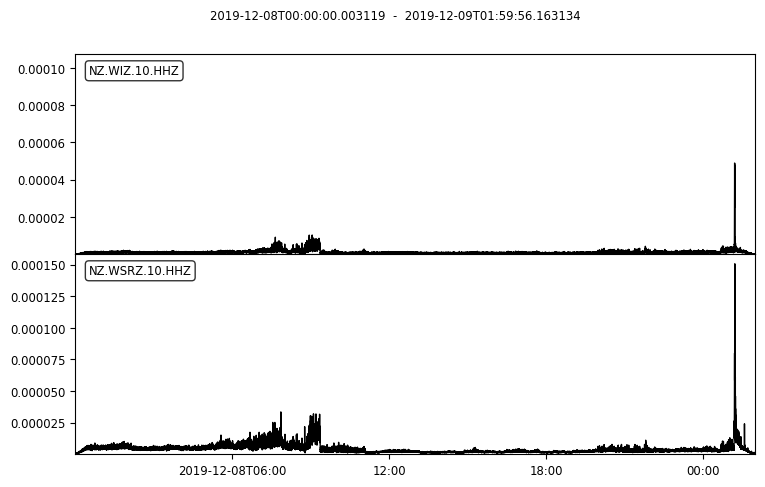

In [4]:
# 2.56-second RSAM
rsam_highrate = compute_rsam(VEL, 2.56)
plot_rsam(rsam_highrate);

NZ.WIZ.10.HHZ: size 9360001
NZ.WIZ.10.HHZ: reshaped to 1560 x 6000 array (9360000 samples)
               network: NZ
               station: WIZ
              location: 10
               channel: HHZ
             starttime: 2019-12-08T00:00:00.003134Z
               endtime: 2019-12-09T01:59:00.003134Z
         sampling_rate: 0.016666666666666666
                 delta: 60.0
                  npts: 1560
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 28666, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 14676992})
            processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 12, 9, 2, 0, 0, 3134)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 12, 8, 0, 0, 0, 3134))', "ObsPy 1.3.0: detrend(options={}::type='linear')", "ObsPy 1.3.0: filter(options={'freqmin':

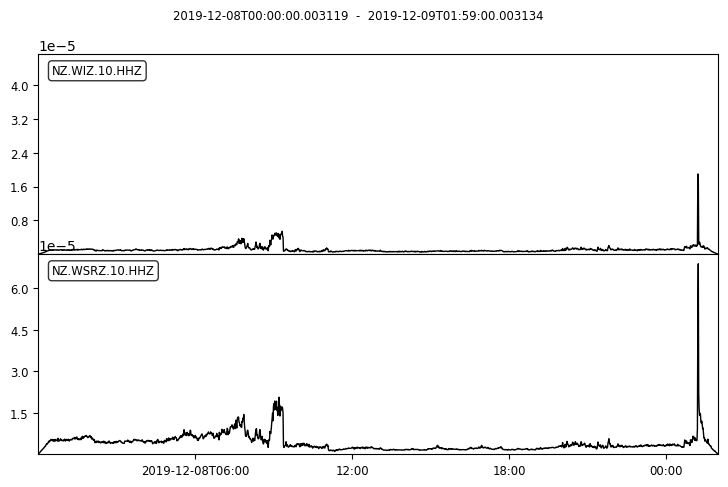

In [5]:
# 1-minute RSAM
rsam1m = compute_rsam(VEL, 60)
plot_rsam(rsam1m);

In [10]:
import pandas as pd
for tr in rsam1m:  
    rsam_file = "%s.%02d.csv" % (tr.id, 1/tr.stats.sampling_rate)
    print(rsam_file)
    write_rsam(rsam_file,tr)
    df = pd.read_csv(rsam_file)
    print(df)


NZ.WIZ.10.HHZ.60.csv
      year   month   day   hour   minute   second          data
0     2019      12     8      0        0        0  1.608299e-08
1     2019      12     8      0        1        0  4.802021e-08
2     2019      12     8      0        2        0  7.936085e-08
3     2019      12     8      0        3        0  1.260760e-07
4     2019      12     8      0        4        0  1.369561e-07
...    ...     ...   ...    ...      ...      ...           ...
1555  2019      12     9      1       55        0  1.574300e-07
1556  2019      12     9      1       56        0  1.308146e-07
1557  2019      12     9      1       57        0  8.783594e-08
1558  2019      12     9      1       58        0  5.759118e-08
1559  2019      12     9      1       59        0  1.741148e-08

[1560 rows x 7 columns]
NZ.WSRZ.10.HHZ.60.csv
      year   month   day   hour   minute   second          data
0     2019      12     8      0        0        0  8.809974e-08
1     2019      12     8      0     

In [ ]:
# # Redoubt volcano eruption, March 2009
# Redoubt volcano in Alaska erupted (at least) 19 times from March-April, 2009. The first magmatic explosion was preceded by an earthquake swarm. Events got closer and closer together, merging into tremor. 

# In[ ]:


import obspy
# Data from Redoubt 2009?
client_iris = obspy.clients.fdsn.Client("IRIS")

# Define the data that we want
start_time = obspy.UTCDateTime("2009-03-22T00:00:00.000")
hours_of_data = 32
end_time = start_time + hours_of_data * 60 * 60
net = "AV" 
stations = ["RSO", "REF"] # two stations on Redoubt Island
chan = "EHZ" # Vertical channel 

# Loading data from the GeoNET client is slow. So when we read it, we will save it to a file. 
# Then if we run this program again, we just need to read the file.
fname = 'Redoubt20090322_VEL.mseed'


# In[ ]:


if os.path.exists(fname):
    # the file already exists, so read it
    print("%s exists. Reading." % fname)
    VEL = obspy.read(fname)
else:
    st = obspy.Stream() # this will hold our raw seismic data
    for station in stations:   
        this_st = client_iris.get_waveforms(net, station,"*", chan, start_time, end_time, attach_response=True)
        this_st.merge(method=1, fill_value=0)
        for tr in this_st:
            st = st.append(tr)
    
    # remove instrument response
    VEL = st.copy()
    VEL.detrend(type='linear') # remove a linear trend
    VEL.filter('bandpass', freqmin=0.5, freqmax=25.0, zerophase=True, corners=2) # filter from 0.5 - 25 Hz
    VEL.remove_response(output='VEL')
    VEL.write(fname)
print(VEL)
print('Done.')
VEL.plot();


# In[ ]:


#VEL.merge()
print(VEL)


# In[ ]:


for tr in VEL:
    tr.plot(type="dayplot")


# In[ ]:


# 1-minute RSAM
rsam1m = compute_rsam(VEL, 10*60)
plot_rsam(rsam1m);


# In[ ]:


# write these RSAM data to file
write_rsam('rsamfile.csv',rsam1m[0])


# In[ ]: